### Poisson regression with PyMC3

In [1]:
%matplotlib inline

import os

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import theano.tensor as ts
import pymc3 as pm

import utils

seed = 504887
plt.style.use("bmh")
plt.rcParams["figure.figsize"] = (8, 6)
np.random.seed(seed)
rng = np.random.RandomState(seed)

In [2]:
data_path = os.path.join("data", "wine_quality.csv")
wine = pd.read_csv(data_path, delimiter=";")
wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


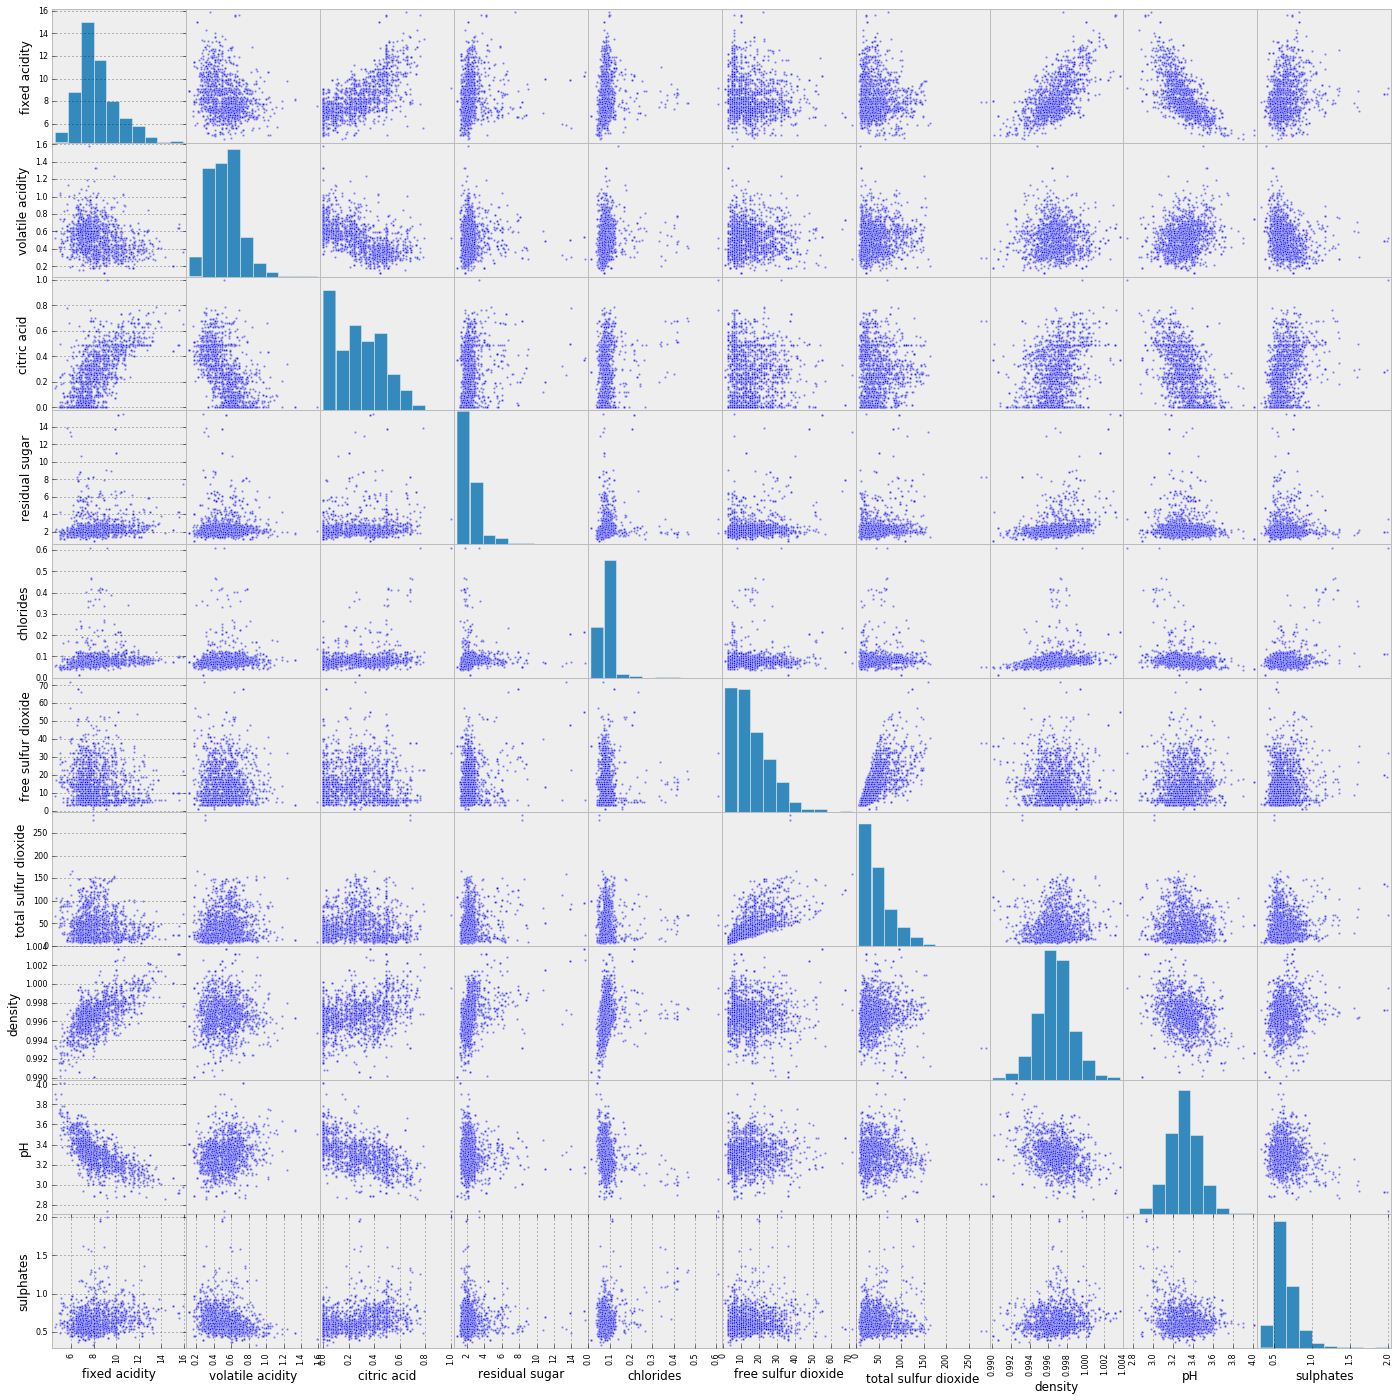

In [3]:
_ = pd.scatter_matrix(wine[wine.columns[:-2]], figsize=(24,24))

<Container object of 6 artists>

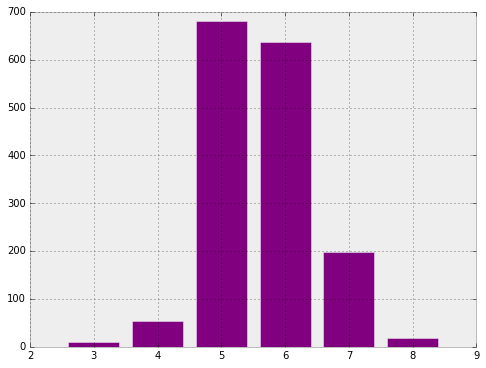

In [4]:
vals,counts = utils.count(wine.quality.values)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.bar(vals, counts, color="purple", align="center")

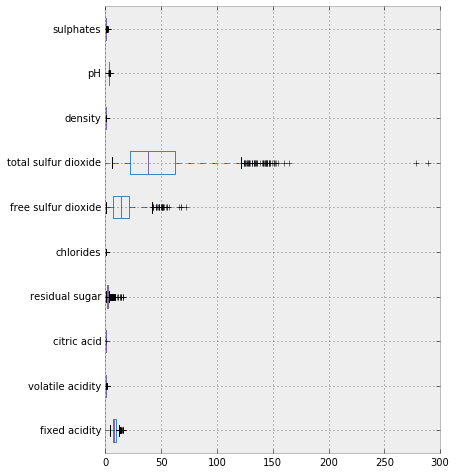

In [5]:
fig = plt.figure(figsize=(6,8))

ax = fig.add_subplot(111)
_= wine[wine.columns[:-2]].boxplot(ax=ax, vert=False)

In [3]:
wine.columns = list(map(lambda s: s.replace(" ","_"), wine.columns))
wine.columns

Index(['fixed_acidity', 'volatile_acidity', 'citric_acid', 'residual_sugar',
       'chlorides', 'free_sulfur_dioxide', 'total_sulfur_dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality'],
      dtype='object')

In [4]:
fa = wine.fixed_acidity.values
va = wine.volatile_acidity.values
ca = wine.citric_acid.values
rs = wine.residual_sugar.values
ch = wine.chlorides.values
fs = wine.free_sulfur_dioxide.values
td = wine.total_sulfur_dioxide.values
dn = wine.density.values
ph = wine.pH.values
sp = wine.sulphates.values
al = wine.alcohol.values
qy = wine.quality.values

data = np.c_[fa,va,ca,rs,ch,fs,td,dn,ph,sp,al]

In [5]:
n,m = data.shape

In [6]:
with pm.Model() as pois_reg:
    alpha = pm.Normal("alpha", mu=1, sd=10, testval=np.random.randn())
    beta = pm.Normal("beta", mu=1, sd=10, shape=m, testval=np.random.randn(m))
    lamda = alpha + ts.dot(data,beta)
    like = pm.Poisson("like", mu=lamda, observed=qy)

In [7]:
pois_reg.vars

[alpha, beta]

In [8]:
with pois_reg:
    start = pm.find_MAP()
    step = pm.NUTS()
    trace_pois_reg = pm.sample(2000, step=step, start=start)

 [-----------------100%-----------------] 2000 of 2000 complete in 272.2 sec

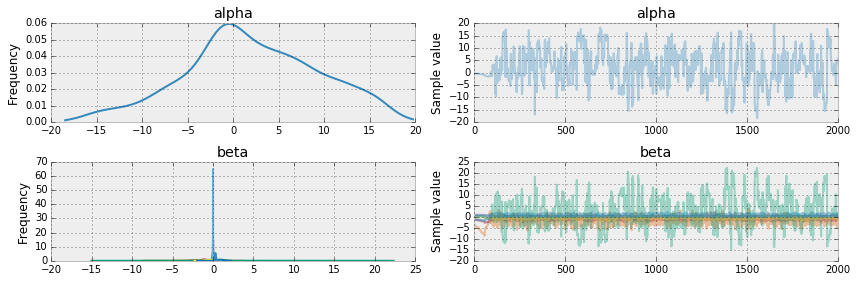

In [9]:
_ = pm.traceplot(trace_pois_reg)

In [28]:
pm.trace_to_dataframe(trace=trace_pois_reg).describe().T

,count,mean,std,min,25%,50%,75%,max
alpha,2000.0,2.038473,7.370410,-18.477615,-2.563060,1.572949,7.292144,19.752772
beta__0,2000.0,0.037882,0.139706,-0.197968,-0.026925,0.014883,0.055980,0.714957
beta__1,2000.0,-1.134737,0.464223,-2.787631,-1.432043,-1.117040,-0.815842,0.356616
beta__2,2000.0,-0.296801,0.617226,-2.643506,-0.634590,-0.260506,0.114773,1.493612
beta__3,2000.0,0.025417,0.094961,-0.162828,-0.019025,0.012171,0.045898,0.541710
beta__4,2000.0,-1.850768,1.712977,-8.635458,-2.910610,-1.761224,-0.748689,3.771230
beta__5,2000.0,0.027380,0.112068,-0.030821,-0.001018,0.004398,0.010267,0.620697
beta__6,2000.0,-0.007791,0.024010,-0.141284,-0.005002,-0.002994,-0.001224,0.010610
beta__7,2000.0,2.153437,7.256314,-15.044351,-2.975072,1.727178,6.784710,22.316373
beta__8,2000.0,-0.521122,0.532477,-2.283580,-0.873723,-0.499604,-0.195089,1.046384


In [26]:
nsamples = 100
like_ppc = pm.sample_ppc(trace_pois_reg, samples=nsamples, model=pois_reg, vars=[like])["like"]
like_ppc

array([[ 4,  5,  4, ...,  2,  5, 12],
       [ 4,  3,  8, ...,  4,  7,  7],
       [ 6,  6,  7, ...,  7,  5,  7],
       ..., 
       [ 4,  8, 11, ...,  7,  4,  5],
       [ 4,  7, 11, ...,  6,  6,  4],
       [ 4,  1,  7, ...,  7,  3,  4]])

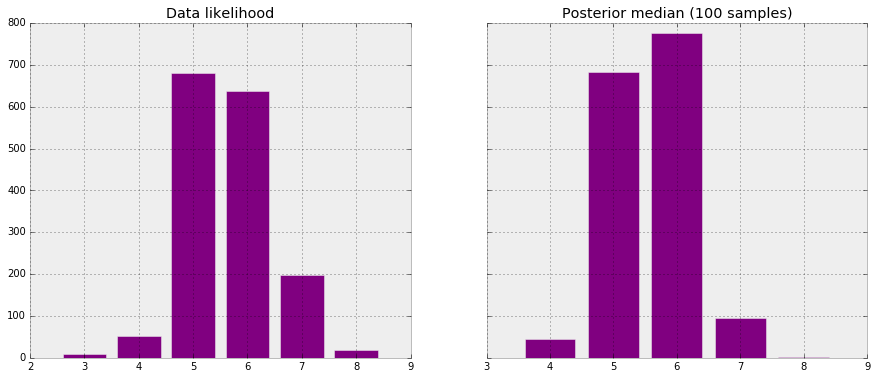

In [27]:
fig,axs = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(15,6))

vals,counts = utils.count(qy)

axs[0].bar(vals, counts, color="purple", align="center")
axs[0].set_title("Data likelihood")

vals,counts = utils.count(np.round(np.median(like_ppc, 0)))

axs[1].bar(vals, counts, color="purple", align="center")
axs[1].set_title("Posterior median (%d samples)" % nsamples)